In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from IPython.display import display
import scipy.stats as stats

# Import our custom function modules
import sampler_functions as sf
import outlier_functions as oef

# Set a nice plot style
sns.set_theme(style="whitegrid")
print("Libraries and modules imported successfully.")

Libraries and modules imported successfully.


In [32]:
# --- 1. Define Experiment Parameters ---

params = {
    'm': 20,
    'k': 2.0,
    'mu_true': 10.0,
    'prior_mean': 0.0,
    'prior_std': 20.0,
    'num_iterations_T': 1000, 
    'proposal_std_mu': 0.9,
    'proposal_std_z': 0.2
}

# Add z_domain to params, as it depends on k
z_domain_half_width = 1 / (2 * np.sqrt(params['k']))
params['z_domain'] = (-z_domain_half_width, z_domain_half_width)

print("Parameters for this run:")
print(params)

Parameters for this run:
{'m': 20, 'k': 2.0, 'mu_true': 10.0, 'prior_mean': 0.0, 'prior_std': 20.0, 'num_iterations_T': 1000, 'proposal_std_mu': 0.9, 'proposal_std_z': 0.2, 'z_domain': (-0.35355339059327373, 0.35355339059327373)}


Outlier threshold L (>99.5th percentile) = 19.9248
25th percentile (Q1): 9.1835, 75th percentile (Q3): 10.8165
Max value in clean dataset (x1): 10.6688
Min value in clean dataset (x1): 9.4310
Max value in outlier dataset (x2): 19.9249
Datasets generated successfully.
[10.19249736  9.43103915  9.77413157  9.57634127  9.72314928 10.24776925
  9.63763099  9.9452555   9.80011189  9.90833454  9.91206299  9.68849723
  9.94085505  9.908318    9.98427102 10.61370622  9.81987729 10.20983611
  9.89969475 10.66883998]
[10.66883998  9.9452555   9.81987729  9.63763099  9.908318    9.68849723
  9.43103915  9.90833454  9.57634127  9.91206299 21.          9.80011189
 10.19249736  9.98427102 10.61370622 10.20983611 10.24776925  9.89969475
  9.94085505  9.72314928]


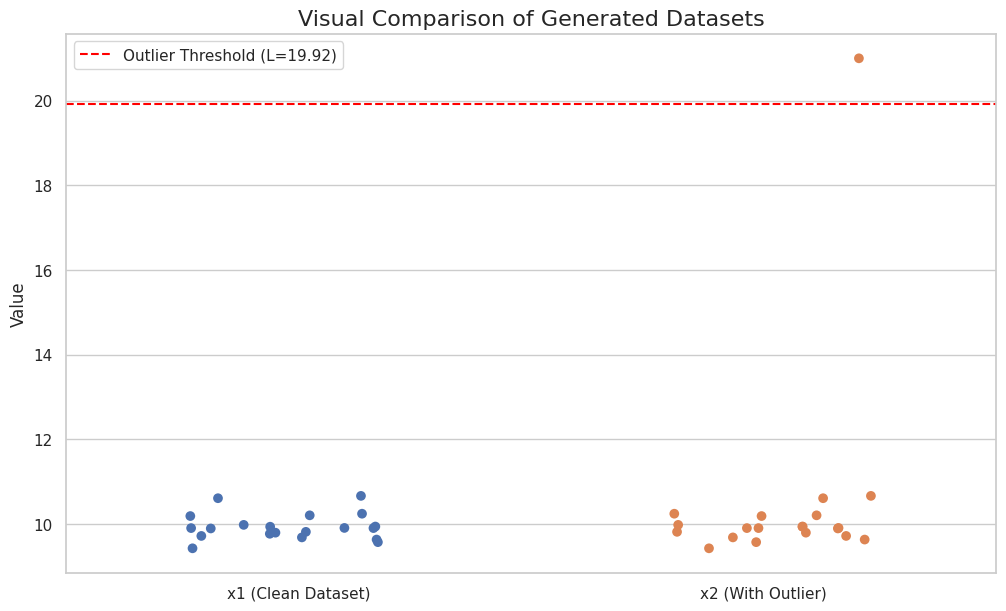

In [33]:
# --- 2. Generate Datasets (Clean vs. Outlier) ---

x1_clean, x2_with_outlier, outlier_threshold_L = sf.generate_datasets(params, outlier_percentile=0.995)

print("Datasets generated successfully.")
print(x1_clean)
#replace the max value of x2_with_outlier with a manually chosen value 
x2_with_outlier = np.where(x2_with_outlier == np.max(x2_with_outlier), 21, x2_with_outlier)
print(x2_with_outlier)
# --- Visualize the generated datasets ---

plt.figure(figsize=(12, 7))
# A strip plot is great for seeing individual points and outliers
sns.stripplot(data=[x1_clean, x2_with_outlier], size=7, jitter=0.25, palette=['#4C72B0', '#DD8452'])

# Add the outlier threshold line for context
plt.axhline(outlier_threshold_L, color='red', linestyle='--', 
            label=f'Outlier Threshold (L={outlier_threshold_L:.2f})')

plt.xticks([0, 1], ['x1 (Clean Dataset)', 'x2 (With Outlier)'])
plt.ylabel("Value")
plt.title("Visual Comparison of Generated Datasets", fontsize=16)
plt.legend()
plt.show()

--- Calculating MLEs for both datasets ---
Calculating MLE for data with 20 points and k=2.0...
Calculating MLE for data with 20 points and k=2.0...
MLE of clean data, μ*(x1):     9.9335
MLE of outlier data, μ*(x2):  9.9535
Difference (μ*(x2) - μ*(x1)): +0.0200


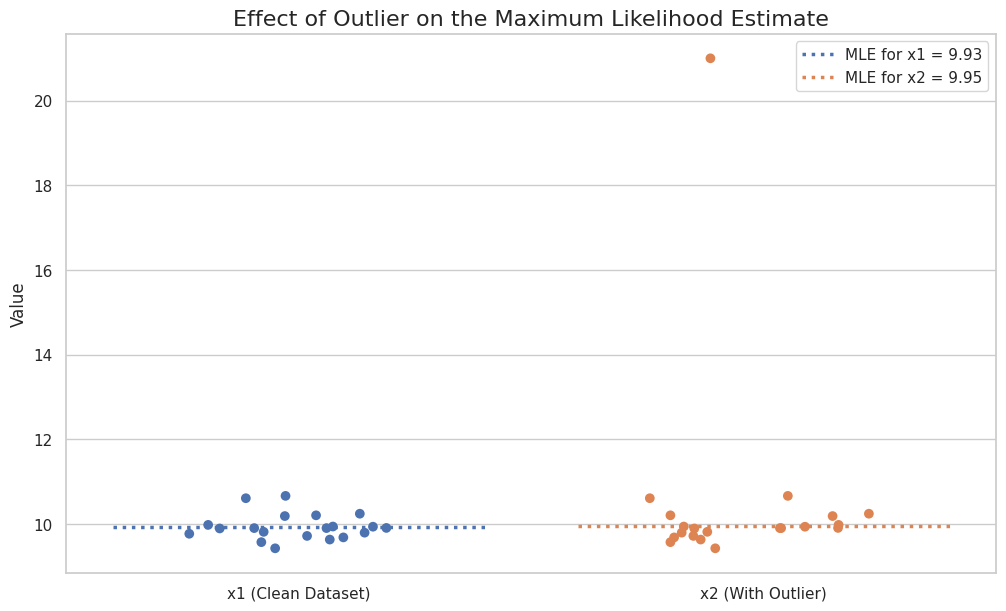

In [34]:
# --- 3. Calculate and Compare MLEs ---

print("--- Calculating MLEs for both datasets ---")
mu_star_1 = sf.get_mle(x1_clean, params)
mu_star_2 = sf.get_mle(x2_with_outlier, params)

print(f"MLE of clean data, μ*(x1):     {mu_star_1:.4f}")
print(f"MLE of outlier data, μ*(x2):  {mu_star_2:.4f}")
print(f"Difference (μ*(x2) - μ*(x1)): {mu_star_2 - mu_star_1:+.4f}")

# --- Visualize the MLEs on the data plots ---
plt.figure(figsize=(12, 7))
sns.stripplot(data=[x1_clean, x2_with_outlier], size=7, jitter=0.25, palette=['#4C72B0', '#DD8452'])

# Add the calculated MLEs as horizontal lines
plt.axhline(mu_star_1, color='#4C72B0', linestyle=':', lw=2.5, xmin=0.05, xmax=0.45, label=f'MLE for x1 = {mu_star_1:.2f}')
plt.axhline(mu_star_2, color='#DD8452', linestyle=':', lw=2.5, xmin=0.55, xmax=0.95, label=f'MLE for x2 = {mu_star_2:.2f}')

plt.xticks([0, 1], ['x1 (Clean Dataset)', 'x2 (With Outlier)'])
plt.ylabel("Value")
plt.title("Effect of Outlier on the Maximum Likelihood Estimate", fontsize=16)
plt.legend()
plt.show()

In [35]:
# --- 4. Generate the Four Posterior Distributions for μ ---

# This is the most computationally intensive part.
print("--- Generating the four posterior distributions for μ ---")
print("This will take some time...")

# Case 1: Posterior from clean, full data -> p(μ | x1)
print("\nRunning sampler for p(μ|x1)...")
mu_chain_x1 = oef.get_full_data_posterior_samples(x1_clean, params)

# Case 2: Posterior from outlier, full data -> p(μ | x2)
print("\nRunning sampler for p(μ|x2)...")
mu_chain_x2 = oef.get_full_data_posterior_samples(x2_with_outlier, params)

# Case 3: Posterior from clean data's MLE -> p(μ | μ*(x1))
print("\nRunning sampler for p(μ|μ*(x1))...")
mu_chain_mle1 = oef.get_mle_conditional_posterior_samples(mu_star_1, params)

# Case 4: Posterior from outlier data's MLE -> p(μ | μ*(x2))
print("\nRunning sampler for p(μ|μ*(x2))...")
mu_chain_mle2 = oef.get_mle_conditional_posterior_samples(mu_star_2, params)

print("\n--- All four posterior chains for μ have been generated successfully. ---")

--- Generating the four posterior distributions for μ ---
This will take some time...

Running sampler for p(μ|x1)...

--- Running Sampler for Full-Data Posterior p(μ|x) ---


Sampling p(μ|x): 100%|██████████| 999/999 [00:01<00:00, 961.09it/s]


Full-data posterior sampling complete.

Running sampler for p(μ|x2)...

--- Running Sampler for Full-Data Posterior p(μ|x) ---


Sampling p(μ|x): 100%|██████████| 999/999 [00:01<00:00, 913.95it/s]


Full-data posterior sampling complete.

Running sampler for p(μ|μ*(x1))...
--- Initializing sampler state ---

--- Starting the Main Gibbs Sampler ---


Running Gibbs Sampler: 100%|██████████| 999/999 [00:31<00:00, 31.96it/s]



--- Sampling Complete ---
Mu Acceptance Rate: 0.3053
Z_i Acceptance Rate: 0.4881

Running sampler for p(μ|μ*(x2))...
--- Initializing sampler state ---

--- Starting the Main Gibbs Sampler ---


Running Gibbs Sampler: 100%|██████████| 999/999 [00:31<00:00, 31.99it/s]


--- Sampling Complete ---
Mu Acceptance Rate: 0.3353
Z_i Acceptance Rate: 0.4912

--- All four posterior chains for μ have been generated successfully. ---


In [36]:
len(np.unique(mu_chain_x1)), len(np.unique(mu_chain_x2)), len(np.unique(mu_chain_mle1)), len(np.unique(mu_chain_mle2))

(293, 261, 306, 336)

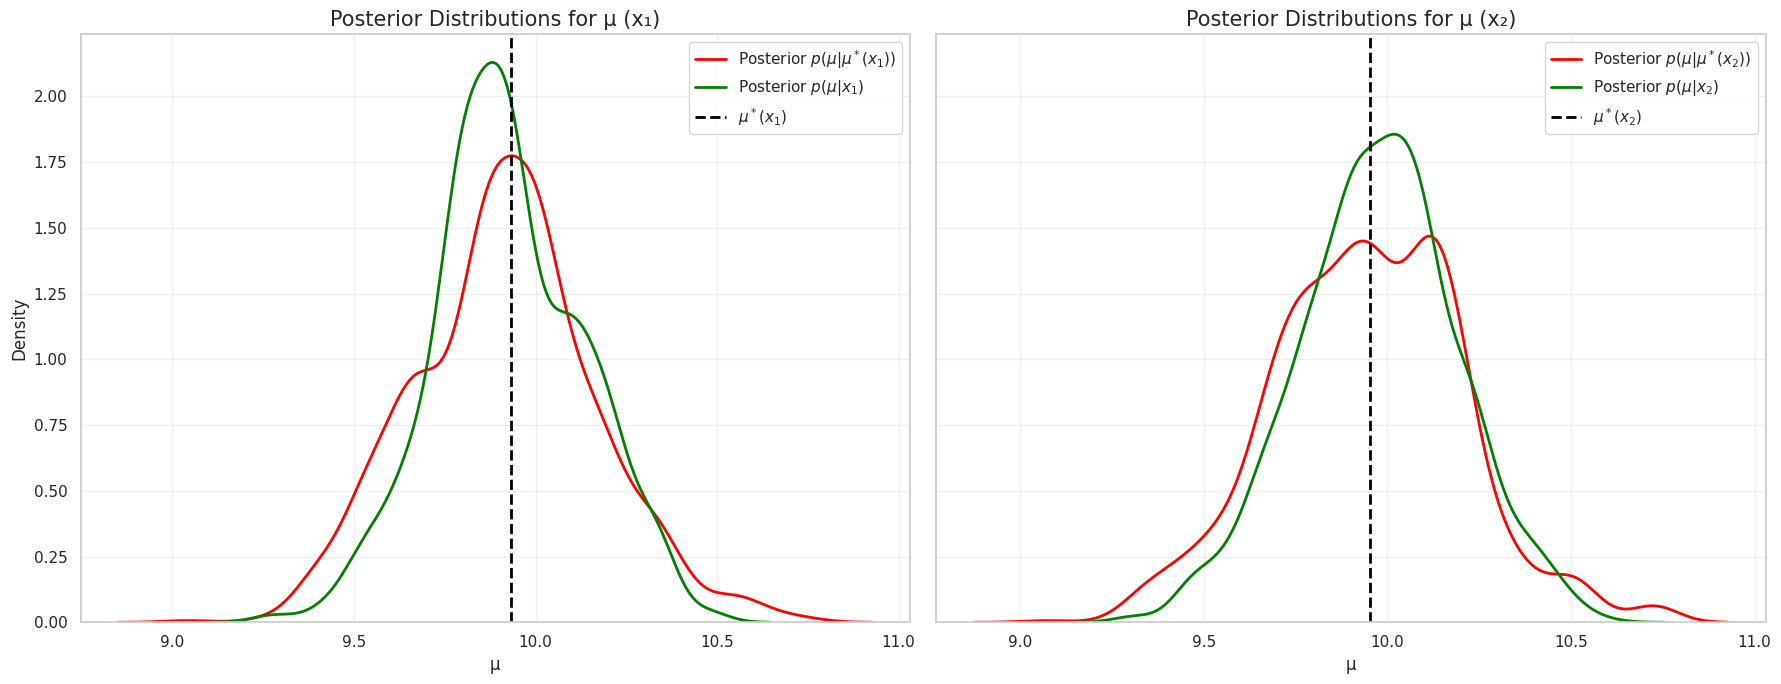

In [37]:

fig, axes = plt.subplots(1, 2, figsize=(18, 7), sharey=True)

# Left: x1
sns.kdeplot(mu_chain_mle1, label="Posterior $p(μ|μ^*(x_1))$", color='red', lw=2, ax=axes[0])
sns.kdeplot(mu_chain_x1, label="Posterior $p(μ|x_1)$", color='green', lw=2, ax=axes[0])
axes[0].axvline(mu_star_1, color='black', linestyle='--', lw=2, label=r"$\mu^*(x_1)$")
axes[0].set_title("Posterior Distributions for μ (x₁)", fontsize=15)
axes[0].set_xlabel("μ")
axes[0].set_ylabel("Density")
axes[0].legend()
axes[0].grid(alpha=0.3)

# Right: x2
sns.kdeplot(mu_chain_mle2, label="Posterior $p(μ|μ^*(x_2))$", color='red', lw=2, ax=axes[1])
sns.kdeplot(mu_chain_x2, label="Posterior $p(μ|x_2)$", color='green', lw=2, ax=axes[1])
axes[1].axvline(mu_star_2, color='black', linestyle='--', lw=2, label=r"$\mu^*(x_2)$")
axes[1].set_title("Posterior Distributions for μ (x₂)", fontsize=15)
axes[1].set_xlabel("μ")
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


In [38]:

# Model parameters
k = params['k']  # degrees of freedom
scale = 1        # fixed scale
m= params['m']  # number of samples to draw for each μ

# Draw one x for each sampled μ
x_pred_mle1 = np.array([stats.t.rvs(df=k, loc=mu, scale=scale, size=m) for mu in mu_chain_mle1]).flatten()
x_pred_x1 = np.array([stats.t.rvs(df=k, loc=mu, scale=scale, size=m) for mu in mu_chain_x1]).flatten()

# Draw one x for each sampled μ
x_pred_mle2 = np.array([stats.t.rvs(df=k, loc=mu, scale=scale, size=m) for mu in mu_chain_mle2]).flatten()
x_pred_x2 = np.array([stats.t.rvs(df=k, loc=mu, scale=scale, size=m) for mu in mu_chain_x2]).flatten()



In [39]:
print(scale)

1


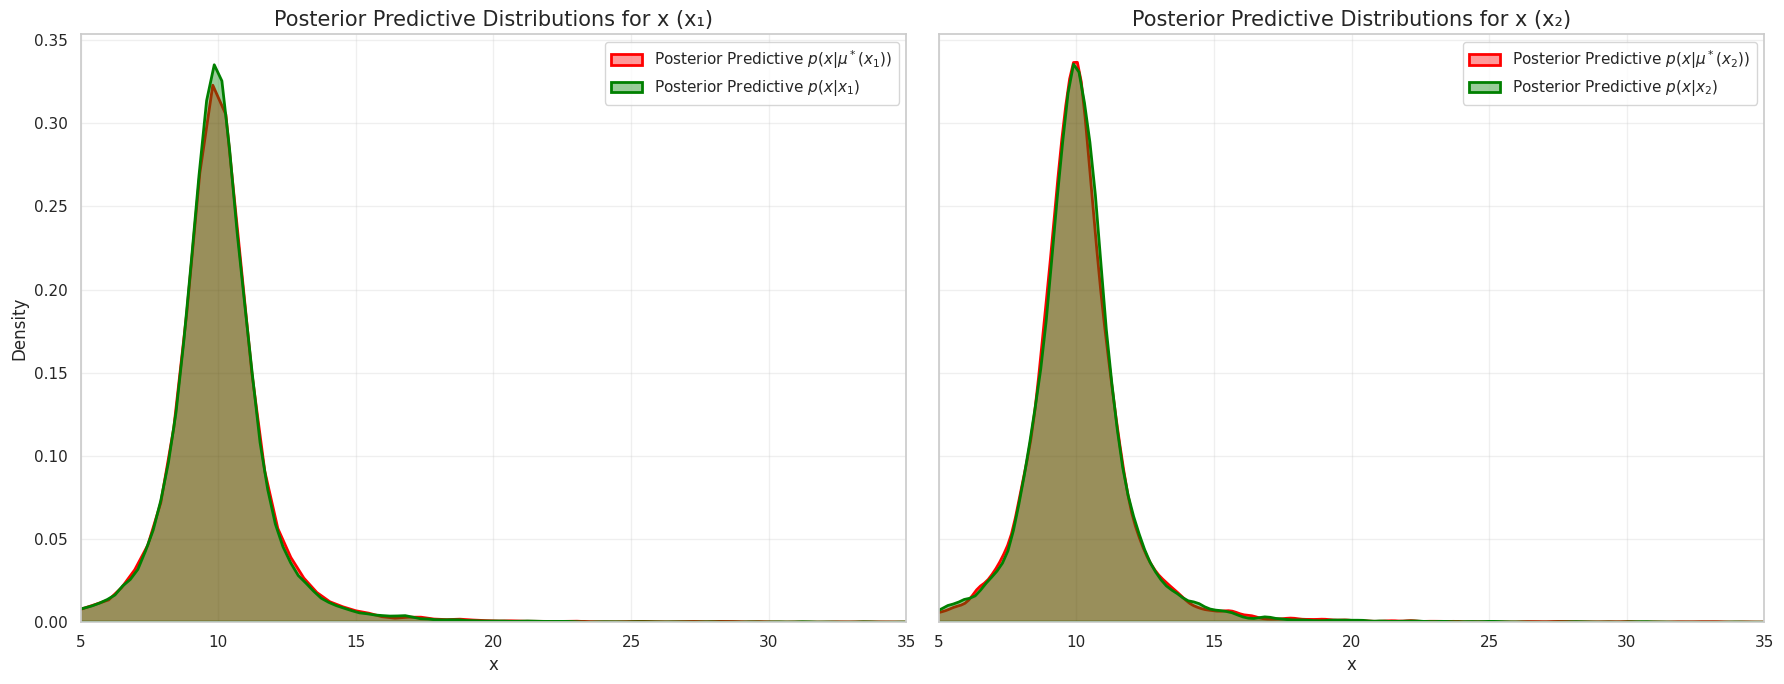

In [40]:

fig, axes = plt.subplots(1, 2, figsize=(18, 7), sharey=True)
xlimit = 20  # Set a limit for the x-axis
bw = 0.5
# Left: x1
axes[0].set_xlim(5, 35)
sns.kdeplot(
    x_pred_mle1, label="Posterior Predictive $p(x|μ^*(x_1))$",
    color='red', lw=2, fill=True, alpha=0.4, bw_adjust=bw, cut=3, gridsize=1000, ax=axes[0]
)
sns.kdeplot(
    x_pred_x1, label="Posterior Predictive $p(x|x_1)$",
    color='green', lw=2, fill=True, alpha=0.4, bw_adjust=bw, cut=3, gridsize=1000, ax=axes[0]
)
axes[0].set_title("Posterior Predictive Distributions for x (x₁)", fontsize=15)
axes[0].set_xlabel("x")
axes[0].set_ylabel("Density")
axes[0].legend()
axes[0].grid(alpha=0.3)

# Right: x2
axes[1].set_xlim(5,35)
sns.kdeplot(
    x_pred_mle2, label="Posterior Predictive $p(x|μ^*(x_2))$",
    color='red', lw=2, fill=True, alpha=0.4, bw_adjust=bw, cut=3, gridsize=1000, ax=axes[1]
)
sns.kdeplot(
    x_pred_x2, label="Posterior Predictive $p(x|x_2)$",
    color='green', lw=2, fill=True, alpha=0.4, bw_adjust=bw, cut=3, gridsize=1000, ax=axes[1]
)
axes[1].set_title("Posterior Predictive Distributions for x (x₂)", fontsize=15)
axes[1].set_xlabel("x")
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()
